In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Starting PreProcessing
Preprocessing Ended
Starting classification
Mean Accuracy score: 
0.5930232558139535
Classification Accuracy (%): 
59.30232558139535
Classification ended


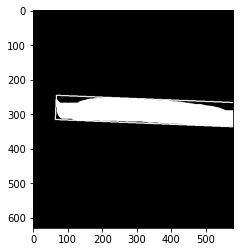

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
!pip install mahotas
import mahotas as mt
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics

#---------------------------- P R E - P R O C E S S I N G   A N D   I M A G E   E N H A N C E M E N T --------------------------
# The function below iterates all images in the specified path and pre-processes them
def PreProcessing(Paths):
    #Stores the resulting vector of pre-preprocessed images' feature vectors
    vector = [] 
    for p in Paths:
        # Every image p in the path specified will be processed / all imgs in the folder
        test_img_path = p
        # OpenCV functions are used for most processes below
        # Display Image 
        main_img = cv2.imread("/content/gdrive/MyDrive/" + test_img_path)

        # 1 - Crop Image / Change aspect ratio to 700x700
        img = cv2.cvtColor(main_img, cv2.COLOR_BGR2BGRA)
        img = cv2.resize(img, (700, 700))
        img = img[0:630, 0:580]
        plt.imshow(img)
        # Visually display the image to see if task performed successfully

        #Image Enhancements:

        # 2 - Convert the image to GrayScale version to perform transformations
        gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plt.imshow(gs, cmap='Greys_r')
        # Visually display the image to see if task performed successfully

        # 3 - Image smoothing using Gaussian filter to remove noise
        blur = cv2.GaussianBlur(gs, (25, 25), 0)
        plt.imshow(blur, cmap='Greys_r')
        # Visually display the image to see if task performed successfully

        #Image Segmentation:

        # 4 - Perform a Image Threshold transformation
        ret_otsu, im_bw_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        plt.imshow(im_bw_otsu, cmap='Greys_r')
        # Visually display the image to see if task performed successfully

        #Image Enhancement
        #Morphological Image processing:
        #(To remove imperfections added from img segmentation)

        # 5 - Closing morphological operation using a kernel
        kernel = np.ones((50, 50), np.uint8)
        closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
        plt.imshow(closing, cmap='Greys_r')
        # Visually display the image to see if task performed successfully

        # 6 - Boundary Extraction using contour tracing for pattern recog
        contours, hierachy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        plottedContour = cv2.drawContours(gs, contours, -1, (0, 255, 0), 10)
        plt.imshow(plottedContour, cmap="Greys_r")
        #  Visually display the image to see if task performed successfully

        #------------- E N D  P R E- P R O C E S S I N G -------------------------
        #Create a feature vector variable
        #Call the FeatureExtraction method to get features for image in p
        #Pass the image, its contours, closed img and grayscale img to the function
        FeatureVector = FeatureExtraction(img, contours, closing, gs)
        # Add the produced feature vector for this image to the first defined
        # vector which will be a vector that stores every feature vector for every
        # image iterated in path p
        vector.append(FeatureVector)

    return vector

# --------------------------------------------------------------------------------------

# ------------ F E A T U R E   E X T R A C T I O N -------------------------------------
def FeatureExtraction(img, contours, closing, gs):
    # This vector stores all features extracted in
    # each process for the final - complete
    # Feature Vector for a parameter passed 
    # pre-processed img
    fv = []

    # Boundry Descriptors:
    # Moments of 2D functions
    M = cv2.moments(contours[0])
    # 1 - Hu's even invariant moments
    H=cv2.HuMoments(M)
    # print(H)
    #fv.append(H)

    # Simple Descriptors:
    # 2 - Area of region
    area = cv2.contourArea(contours[0])
    # print(area)
    fv.append(area)

    # 3 - Perimeter of region
    perimeter = cv2.arcLength(contours[0], True)
    # print(perimeter)
    fv.append(perimeter)

    # Shape Features:
    # 4 - Best fit rectangle for bounding regions
    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    contours_im = cv2.drawContours(closing, [box], 0, (255, 255, 255), 2)
    plt.imshow(contours_im, cmap="Greys_r")
    # plt.show()
    # Bound the rectangle
    x, y, w, h = cv2.boundingRect(contours[0])
    aspect_ratio = 0 if h == 0 else float(w) / h
    # print(aspect_ratio)
    fv.append(aspect_ratio)

    # 5 - Rectangularity coordinate system for img
    rectangularity = 0 if area == 0 else w * h / area
    # print(rectangularity)
    fv.append(rectangularity)

    # 6 - Cicularity coordinate system for img
    circularity = 0 if area == 0 else ((perimeter) ** 2) / area
    # print(circularity)
    fv.append(circularity)

    # 7 - ESD - Equivalent Spherical Diameter
    equi_diameter = np.sqrt(4 * area / np.pi)
    # print(equi_diameter)
    fv.append(equi_diameter)

    #Colour based features:
    # RGB channel value extraction
    red_channel = img[:, :, 0]
    # plt.imshow(red_channel,cmap="Greys_r")
    # plt.show()
    green_channel = img[:, :, 1]
    # plt.imshow(green_channel,cmap="Greys_r")
    # plt.show()
    blue_channel = img[:, :, 2]
    # plt.imshow(blue_channel,cmap="Greys_r")
    # plt.show()
    blue_channel[blue_channel == 255] = 0
    red_channel[red_channel == 255] = 0
    green_channel[green_channel == 255] = 0

    #Statistical moments (for colours):
    # 8, 9, 10 - Mean values for RGB 
    blue_mean = np.mean(blue_channel)
    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    # print(blue_mean, red_mean, green_mean)
    fv.append(blue_mean)
    fv.append(red_mean)
    fv.append(green_mean)

    # 11, 12, 13 - Std deviations for RGB
    blue_std = np.std(blue_channel)
    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    fv.append(blue_std)
    fv.append(red_std)
    fv.append(green_std)



    # Textural features/descriptors:
    # Haralick feature extraction (4/13 features used):
    textures = mt.features.haralick(gs)
    ht_mean = textures.mean(axis=0)
    # 14 - Contrast extraction
    contrast = ht_mean[1]
    # 15 - Contrast extraction
    correlation = ht_mean[2]
    # 16 - Inverse Difference Moment extraction
    idm = ht_mean[4]
    # 17 - Entropy extraction
    entropy = ht_mean[8]
    # print(ht_mean[1])
    fv.append(contrast)
    fv.append(correlation)
    fv.append(idm)
    fv.append(entropy)
    #print(fv)
    #for k,v in fv[0].items():
     # list1.append[k]
    #print(list1)
    return fv  #Return feature vector back to PreProcessing() for output

#-------------------------------------------------------------------------------

# --------- I M A G E   C L A S S I F I C A T I O N ----------------------------
# Retrieving class names as well as image paths 
# For each set of data, namely the training image data set and
# the testing/comparison image dataset

# D A T A  E X T R A C T I O N

#Training Set
col_names = ['image_path', 'species']
training_set = pd.read_csv("/content/gdrive/MyDrive/Train_Set.csv", usecols=col_names)
#print(training_set["species"].head())
Training_Path = training_set.image_path.tolist()
#print(Training_Path)
Training_labels = training_set.species.tolist()
#print(Training_labels)

#Pre-processing all the images in the path found for feature extraction
print("Starting PreProcessing")
#SToring the vector of:feature-vectors obtained from the pre-processed images
Feature_vector_training = PreProcessing(Training_Path)

#print(Feature_vector_training)

#Successfully preprocessing message with no issues
print("Preprocessing Ended")

#Testing Set
testing_set = pd.read_csv("/content/gdrive/MyDrive/Test_Set.csv", usecols=col_names)
#print(test_set["species"].head())
Testing_Path = testing_set.image_path.tolist()
#print(Training_Path)
y_testLabels = testing_set.species.tolist()
#print("Starting PreProcessing Again")

x_test = PreProcessing(Testing_Path)
#print("Preprocessing Ended Again")

print("Starting classification")


# Classification technique:
# Support Vector Machine
# Creating the classifier using SVM called from sklearn lib
# and setting to a linear kernel for smooth analysis
clsf = SVC(kernel='linear')
# Training the SVM by passing the training feature vectors
# and class labels for interpretation of the image data
clsf.fit(Feature_vector_training, Training_labels)

#Testing the model against the test images for accuracy
testPred = clsf.predict(x_test)
#print(testPred)
#print("Accuracy: ",metrics.accuracy_score(x_test, testPred))
print("Mean Accuracy score: ")
#Displaying the mean accuracy score after testing the images against
# the trained system
print(clsf.score(x_test,y_testLabels))
accurRate= (clsf.score(x_test,y_testLabels))*100
print("Classification Accuracy (%): ")
print(accurRate)
print("Classification ended")